In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from multicam.models import MultiCamSampling
from multicam.models import _get_tt_indices
from multicam.correlations import spearmanr

import warnings
from pandas.errors import ParserWarning

warnings.simplefilter(action='ignore', category=ParserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
dsdf = pd.read_csv(
    'data/gadgetx3k_20/G3X_progenitors/DS_G3X_snap_128_center-cluster_progenitors.txt',
    sep=r'\s+', header=0)

int_columns = [0, 1, 2, 7]
column_names = dsdf.columns

for idx in range(len(column_names)):
    col_name = column_names[idx]
    if idx in int_columns:
        dsdf[col_name] = dsdf[col_name].astype(int)
    else:
        dsdf[col_name] = dsdf[col_name].astype(float)

dsdf.drop(columns=['rID[0]', 'Hid[1]', 'DS_200[2]', 'DS_500[7]'], inplace=True)
dsdf = dsdf[:20]       # there are only MAH for the first 20 regions

In [38]:
mah_data = []
for indx in np.arange(1, 21):
    mah_file = f'data/gadgetx3k_20/AHF_History/NewMDCLUSTER_{str(indx).zfill(4)}_halo_128000000000001.dat'
    mah_df = pd.read_csv(mah_file, sep=r'\s+', index_col=False)

    mah_df['M/M0'] = mah_df['Mvir(4)'].values/mah_df['Mvir(4)'][0]
    mah_df['aexp'] = 1/(1+mah_df['Redshift(0)'])
    mah_data.append(mah_df)

In [39]:
n_snaps = [len(df) for df in mah_data]
most_snaps_indx = np.argmax(n_snaps)
aexp = mah_data[most_snaps_indx]['aexp']
n_regions = 20
mah_ds_dict = {}
for a in aexp:
    # setup df for all MM0 values at this snap
    mah_df = pd.DataFrame(columns=['M/M0'])
    bad_regions = [] # indices for regions without MM0 at this snap
    for region in range(20):
        row = mah_data[region].loc[mah_data[region]
                                      ['aexp'] == a, ['M/M0']]

        if not row.empty:   # then there is an MM0 value for this region at snap
            mah_df = pd.concat([mah_df, row], ignore_index=True)
        else: bad_regions.append(region)

    if len(bad_regions) != 0:
        ds = dsdf.drop(bad_regions, axis=0)
    else: ds = dsdf

    if len(ds) < n_regions:
        aexp = aexp[aexp != a]
        continue

    df = pd.concat([mah_df.reset_index(drop=True),
                   ds.reset_index(drop=True)], axis=1)
    mah_ds_dict[a] = df

In [9]:
eta_200 = dsdf['eta_200[3]']
delta_200 = dsdf['delta_200[4]']
fm_200 = dsdf['fm_200[5]']
fm2_200 = dsdf['fm2_200[6]']

eta_500 = dsdf['eta_500[8]']
delta_500 = dsdf['delta_500[9]']
fm_500 = dsdf['fm_200[5]']
fm2_500 = dsdf['fm2_500[11]']

In [69]:
min_snaps = np.min(n_snaps)
n_features = int(min_snaps)  # number of features is the number of scales
n_targets = 1  # number of targets is 1, the present-day halo property
model = MultiCamSampling(n_features, n_targets)

train_idx, test_idx = _get_tt_indices(n_regions, test_ratio=0.25)

In [70]:
mah = [df['M/M0'] for df in mah_data]
ma = [df.sample(min_snaps) for df in mah]
ma = np.array(ma)

In [71]:
ma_train = ma[train_idx]
ma_test = ma[test_idx]
eta_train = eta_200[train_idx]
eta_test = eta_200[test_idx]

In [72]:
model.fit(ma_train, eta_train.values.reshape(15, 1))  # reshape to 2D array

In [73]:
eta_pred = model.predict(ma_test)

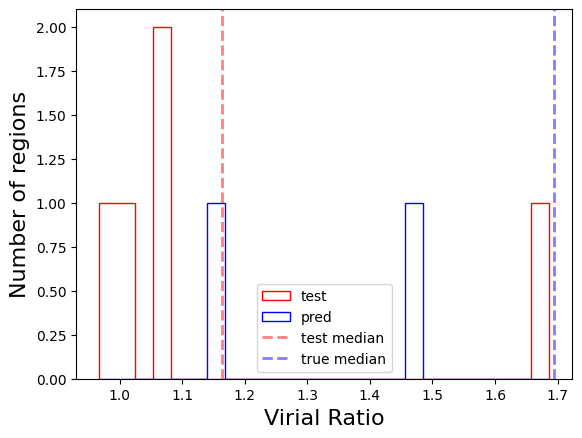

In [74]:
_, bins, _ = plt.hist(eta_test, label='test',
                      histtype='step', bins=25, color='r')
plt.hist(eta_pred, label='pred', histtype='step', bins=bins, color='b')
plt.axvline(np.mean(eta_test),  ls='--',
            label='test median', alpha=0.5, lw=2, color='r')
plt.axvline(np.mean(eta_pred), ls='--',
            label='true median', alpha=0.5, lw=2, color='b')
plt.xlabel('Virial Ratio', fontsize=16)
plt.ylabel('Number of regions', fontsize=16)
plt.legend()
plt.show()

In [75]:
spearmanr(eta_test, eta_pred)

np.float64(0.8207826816681233)

# Multivariable Prediction

In [79]:
min_snaps = np.min(n_snaps)
n_features = int(min_snaps)  # number of features is the number of scales
n_targets = 4
mv_model = MultiCamSampling(n_features, n_targets)

train_idx, test_idx = _get_tt_indices(n_regions, test_ratio=0.25)

In [100]:
x = ma 
y = np.vstack([eta_200, delta_200, fm_200, fm2_200]).T # just need to remember the order of the targets
x.shape, y.shape

((20, 87), (20, 4))

In [101]:
train_idx, test_idx = _get_tt_indices(n_regions, test_ratio=0.25)
x_train = x[train_idx]
x_test = x[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

In [102]:
mv_model.fit(x_train, y_train)

In [103]:
y_pred = mv_model.predict(x_test)

In [104]:
# compute spearman correlation for each target
target_names = ['eta', 'delta', 'fm', 'fm2']
for i in range(n_targets):
    print(f'{target_names[i]}:', spearmanr(y_test[:, i], y_pred[:, i]))

eta: -0.3
delta: -0.3
fm: -0.7
fm2: -0.8720815992723809
